In [601]:
import os
import pandas as pd
import numpy as np
import talib
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

pd.set_option('display.max_columns', None) 

In [602]:
# データの読み込み
def load_data(file_names):
    dfs = []
    for file_name in file_names:
        df = pd.read_csv(file_name)
        dfs.append(df)
    return dfs

## 対数化
- 対数化は、データの値を対数変換することによって、分布の歪みを軽減するために行う
- この処理は、正規分布に近づけることで機械学習モデルの精度を向上させるために行われる

## 標準化
- 標準化は、データの平均値を0に、標準偏差を1にするように変換することで、異なる尺度のデータを比較可能にするために行う
- この処理は、異なる尺度の特徴量を扱う際に、データのバランスを取るために行われる

- 対数化はデータの分布を整えることを目的とし、標準化はデータのスケールを統一することを目的としている
- どちらの処理も、データの前処理として機械学習モデルの精度向上に役立つ

In [621]:
# 特徴量エンジニアリング
def feature_engineering(df, prefix):
    open = df[f'{prefix}_open'].values
    high = df[f'{prefix}_high'].values
    low = df[f'{prefix}_low'].values
    close = df[f'{prefix}_close'].values
    volume = df[f'{prefix}_volume'].values
    hilo = (high + low) / 2

    # TA-Libを使用して一般的なテクニカル指標を計算
    # 標準化：　closeで割る
    # 対数化：　numpyで対数変換する
    df[f'{prefix}_RSI_ST'] = talib.RSI(close)/close
    df[f'{prefix}_RSI_LOG'] = log_transform_feature(talib.RSI(close))
    df[f'{prefix}_MACD'], _, _ = talib.MACD(close)
    df[f'{prefix}_MACD_ST'], _, _ = talib.MACD(close)/close
    df[f'{prefix}_ATR'] = talib.ATR(high, low, close)
    # df[f'{prefix}_ADX'] = talib.ADX(high, low, close)
    df[f'{prefix}_SMA10_ST'] = talib.SMA(close, timeperiod=10)/close
    df[f'{prefix}_SMA10_LOG'] = log_transform_feature(talib.SMA(close, timeperiod=10))
    df[f'{prefix}_SMA50_ST'] = talib.SMA(close, timeperiod=50)/close
    df[f'{prefix}_SMA50_LOG'] = log_transform_feature(talib.SMA(close, timeperiod=50))
    df[f'{prefix}_SMA100_ST'] = talib.SMA(close, timeperiod=100)/close
    df[f'{prefix}_SMA100_LOG'] = log_transform_feature(talib.SMA(close, timeperiod=100))
    df[f'{prefix}_SMA200_ST'] = talib.SMA(close, timeperiod=200)/close
    df[f'{prefix}_SMA200_LOG'] = log_transform_feature(talib.SMA(close, timeperiod=200))
    # df[f'{prefix}_EMA'] = talib.EMA(close, timeperiod=30)/close
    df[f'{prefix}_BB_UPPER'], df[f'{prefix}_BB_MIDDLE'], df[f'{prefix}_BB_LOWER'] = talib.BBANDS(close)
    df[f'{prefix}_BBANDS_upperband'] = (df[f'{prefix}_BB_UPPER'] - hilo) / close
    df[f'{prefix}_BBANDS_middleband'] = (df[f'{prefix}_BB_MIDDLE'] - hilo) / close
    df[f'{prefix}_BBANDS_lowerband'] = (df[f'{prefix}_BB_LOWER'] - hilo) / close
    
    df[f'{prefix}_STOCH_K'], df[f'{prefix}_STOCH_D'] = talib.STOCH(high, low, close)/close
    df[f'{prefix}_AD'] = talib.AD(high, low, close, volume)
    df[f'{prefix}_MON'] = talib.MOM(close, timeperiod=5)
    df[f'{prefix}_RCI9'] = RCI(df, prefix, period=9)/close
    df[f'{prefix}_RCI26'] = RCI(df, prefix, period=26)/close
    df[f'{prefix}_RCI52'] = RCI(df, prefix, period=52)/close
    df[f'{prefix}_RCI9_LOG'] = log_transform_feature(RCI(df, prefix, period=9))
    df[f'{prefix}_RCI26_LOG'] = log_transform_feature(RCI(df, prefix, period=26))
    df[f'{prefix}_RCI52_LOG'] = log_transform_feature(RCI(df, prefix, period=52))
    df[f'{prefix}_OBV'] = talib.OBV(close, volume)
    df[f'{prefix}_WMA'] = talib.WMA(close)
    df[f'{prefix}_DEMA'] = talib.DEMA(close)
    df[f'{prefix}_HT_TRENDLINE'] = talib.HT_TRENDLINE(close)
    df[f'{prefix}_APO'] = talib.APO(close)
    df[f'{prefix}_PPO'] = talib.PPO(close)
    df[f'{prefix}_DEMA'] = talib.DEMA(close, timeperiod=30)
    df[f'{prefix}_WMA'] = talib.WMA(close, timeperiod=30)
    df[f'{prefix}_LINEARREG'] = talib.LINEARREG(close, timeperiod=14)/close
    df[f'{prefix}_CMO'] = talib.CMO(close, timeperiod=14)/close
    df[f'{prefix}_WILLR'] = talib.WILLR(high, low, close, timeperiod=14)
    df[f'{prefix}_OBV'] = talib.OBV(close, volume)
        
#         DF["OBV"]=0.0
#     volume=np.array(DF["expVolume"])
#     obv=talib.OBV(close,volume)
    # df[f'{prefix}_OBV'] = talib.OBV(close)
    
    # # ラグ特徴量
    df[f'{prefix}_lag1'] = df[f'{prefix}_close'].shift(1)
    df[f'{prefix}_lag2'] = df[f'{prefix}_close'].shift(2)


    # 欠損値の削除
    df = df.dropna()
    df = df.reset_index(drop=True)

    return df

# X: 特徴量の行列 (2次元ndarray)
def log_transform_feature(X):
    # ゼロ以下の値を持つ場合は、値を補正してから対数変換する
    X[X <= 0] = np.finfo(float).eps
    # 特徴量の対数変換を行う
    return np.log(X)

# 結合のデータフレームに特徴量を追加
def add_features(df):
    df.set_index('15m_timestamp', inplace=True)
    df.index = pd.to_datetime(df.index)
    # df['weekday'] = df.index.weekday
    # df['month'] = df.index.month
    # df['year'] = df.index.year
    
    return df

def RCI(df, prefix, period=9):
    def rank(series):
        temp = series.argsort()
        ranks = np.empty_like(temp)
        ranks[temp] = np.arange(len(series))
        return len(series) - ranks

    def calculate_rci(prices, period):
        r = np.sum((rank(prices) - rank(np.roll(prices, period))) ** 2)
        return 1 - 6 * r / (period * (period ** 2 - 1))

    return df[f'{prefix}_close'].rolling(window=period).apply(calculate_rci, args=(period,), raw=True)

In [611]:
# ラベルデータ作成
def create_label(df, prefix, lookahead=1):
    df[f'{prefix}_target'] = (df[f'{prefix}_close'].shift(-lookahead) > df[f'{prefix}_close']).astype(int)
    df = df.dropna()
    return df

In [612]:
# 学習曲線のグラフを表示する関数
def plot_learning_curve(evals_result):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.plot(np.arange(len(evals_result['training']['binary_logloss'])),
            evals_result['training']['binary_logloss'], label='Training')
    ax.plot(np.arange(len(evals_result['valid_1']['binary_logloss'])),
            evals_result['valid_1']['binary_logloss'], label='Validation')
    ax.set_title('Learning Curve')
    ax.set_xlabel('Boosting Round')
    ax.set_ylabel('Binary Logloss')
    ax.legend()
    plt.show()


# 特徴量の重要度を表示する関数
def plot_feature_importance(model, feature_names):
    importance = pd.DataFrame({"Feature": feature_names,
                               "Importance": model.feature_importance()})
    importance.sort_values(by="Importance", ascending=False, inplace=True)
    plt.figure(figsize=(10, 10))
    sns.barplot(x="Importance", y="Feature", data=importance)
    plt.title("Feature Importance")
    plt.tight_layout()
    plt.show()

In [615]:
# 学習と評価
def train_and_evaluate(df):
    features = df.drop(['15m_target', '1h_timestamp', '4h_timestamp'], axis=1)
    labels = df['15m_target']

    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test)

    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.9
    }

    verbose_eval = 0  # この数字を1にすると学習時のスコア推移がコマンドライン表示される
    evals_result = {}  # 学習結果を格納するための空の辞書
    
    # create a callback that records the evaluation history into evals_result
    record_evaluation = lgb.record_evaluation(evals_result)

    model = lgb.train(
        params=params,
        train_set=train_data,
        valid_sets=[train_data, test_data],
        num_boost_round=10000,  # 最大学習サイクル数。early_stopping使用時は大きな値を入力
        callbacks=[lgb.early_stopping(stopping_rounds=10, 
                verbose=True), # early_stopping用コールバック関数
                lgb.log_evaluation(verbose_eval), # コマンドライン出力用コールバック関数
                record_evaluation]
    )

    y_pred = model.predict(X_test)
    y_pred = np.round(y_pred).astype(int)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy}")
    print(classification_report(y_test, y_pred))
    
    # 学習曲線のグラフを表示
    plot_learning_curve(evals_result)

    # 特徴量の重要度を表示
    plot_feature_importance(model, features.columns)

    return model

,15m_timestamp,15m_open,15m_high,15m_low,15m_close,15m_volume,15m_RSI_ST,15m_RSI_LOG,15m_MACD,15m_MACD_ST,15m_ATR,15m_SMA10_ST,15m_SMA10_LOG,15m_SMA50_ST,15m_SMA50_LOG,15m_SMA100_ST,15m_SMA100_LOG,15m_SMA200_ST,15m_SMA200_LOG,15m_BB_UPPER,15m_BB_MIDDLE,15m_BB_LOWER,15m_BBANDS_upperband,15m_BBANDS_middleband,15m_BBANDS_lowerband,15m_STOCH_K,15m_STOCH_D,15m_AD,15m_MON,15m_RCI9,15m_RCI26,15m_RCI52,15m_RCI9_LOG,15m_RCI26_LOG,15m_RCI52_LOG,15m_OBV,15m_WMA,15m_DEMA,15m_HT_TRENDLINE,15m_APO,15m_PPO,15m_LINEARREG,15m_CMO,15m_WILLR,15m_lag1,15m_lag2,15m_target,1h_timestamp,1h_open,1h_high,1h_low,1h_close,1h_volume,1h_RSI_ST,1h_RSI_LOG,1h_MACD,1h_MACD_ST,1h_ATR,1h_SMA10_ST,1h_SMA10_LOG,1h_SMA50_ST,1h_SMA50_LOG,1h_SMA100_ST,1h_SMA100_LOG,1h_SMA200_ST,1h_SMA200_LOG,1h_BB_UPPER,1h_BB_MIDDLE,1h_BB_LOWER,1h_BBANDS_upperband,1h_BBANDS_middleband,1h_BBANDS_lowerband,1h_STOCH_K,1h_STOCH_D,1h_AD,1h_MON,1h_RCI9,1h_RCI26,1h_RCI52,1h_RCI9_LOG,1h_RCI26_LOG,1h_RCI52_LOG,1h_OBV,1h_WMA,1h_DEMA,1h_HT_TRENDLINE,1h_APO,1h_PPO,1h_LINEARREG,1h_CMO,1h_WILLR,1h_lag1,1h_lag2,1h_target,4h_timestamp,4h_open,4h_high,4h_low,4h_close,4h_volume,4h_RSI_ST,4h_RSI_LOG,4h_MACD,4h_MACD_ST,4h_ATR,4h_SMA10_ST,4h_SMA10_LOG,4h_SMA50_ST,4h_SMA50_LOG,4h_SMA100_ST,4h_SMA100_LOG,4h_SMA200_ST,4h_SMA200_LOG,4h_BB_UPPER,4h_BB_MIDDLE,4h_BB_LOWER,4h_BBANDS_upperband,4h_BBANDS_middleband,4h_BBANDS_lowerband,4h_STOCH_K,4h_STOCH_D,4h_AD,4h_MON,4h_RCI9,4h_RCI26,4h_RCI52,4h_RCI9_LOG,4h_RCI26_LOG,4h_RCI52_LOG,4h_OBV,4h_WMA,4h_DEMA,4h_HT_TRENDLINE,4h_APO,4h_PPO,4h_LINEARREG,4h_CMO,4h_WILLR,4h_lag1,4h_lag2,4h_target
0,1627923600000,39813.76,39880.66,39632.47,39661.93,0.174250,0.001270,3.919780,51.053205,0.001287,192.770271,1.002116,10.590260,1.000053,10.588200,1.009899,10.597998,1.029959,10.617666,39958.946842,39786.962,39614.977158,0.005103,0.000766,-0.003570,0.000939,0.001391,-13.217061,-43.48,0.000025,0.000025,0.000025,0.0,0.0,0.0,-21.411204,39613.019914,39619.061200,39598.556765,166.553205,0.421077,1.003786,0.000020,-56.276920,39813.76,39779.08,1,1.628464e+12,44201.21,44452.77,43676.82,43807.74,13.693585,0.001078,3.854878,14.072833,0.000321,582.414491,1.001374,10.688938,1.001292,10.688857,0.960107,10.646855,0.933131,10.618356,44410.560633,43956.444,43502.327367,0.007893,-0.002473,-0.012839,0.001588,0.001554,-6.230848,216.51,0.000023,0.000023,0.000023,0.0,0.0,0.0,-50.218680,44161.473935,44377.634225,44257.634000,-234.890897,-0.530792,0.998250,-0.000127,-72.611731,44201.21,44256.35,0.0,1.630613e+12,49270.31,49809.71,49231.18,49231.18,42.787260,0.001182,4.063858,400.775672,0.008141,805.495813,0.994110,10.798375,0.977522,10.781548,0.972698,10.776601,0.927696,10.729231,50213.523722,49577.510,48941.496278,0.014078,0.001159,-0.011760,0.000742,0.001222,292.397701,-306.05,0.000020,0.000020,0.000020,0.0,0.0,0.0,-55.900882,48374.795290,48754.175593,48161.517799,436.338205,0.905334,1.015385,0.000333,-28.632984,49270.31,49496.94,1.0
1,1627925400000,39758.37,39806.92,39680.40,39720.61,0.149088,0.001329,3.966204,48.597733,0.001223,189.357394,1.000866,10.590491,0.998597,10.588222,1.008118,10.597711,1.028219,10.617454,39959.349272,39780.360,39601.370728,0.005430,0.000924,-0.003582,0.000779,0.001102,-13.271384,-33.01,0.000025,0.000025,0.000025,0.0,0.0,0.0,-21.262116,39622.891161,39629.567263,39619.948350,175.533782,0.443776,1.001968,0.000140,-56.166996,39661.93,39813.76,0,1.628471e+12,43180.58,43349.71,42820.94,43105.47,6.731396,0.000906,3.664838,-59.871776,-0.001389,611.299170,1.015844,10.687125,1.017756,10.689005,0.976539,10.647665,0.948545,10.618580,44660.119817,43838.024,43015.928183,0.036534,0.017462,-0.001610,0.000970,0.001424,-5.717945,-592.10,0.000023,0.000023,0.000023,0.0,0.0,0.0,-56.950076,44091.696710,44244.315295,44231.166967,-358.545641,-0.810883,1.009691,-0.000508,-87.856686,43807.74,44201.21,1.0,1.630642e+12,49447.47,49730.23,49226.00,49251.72,38.248366,0.001185,4.066987,400.942306,0.008141,783.976826,0.996908,10.801603,0.977332,10.781771,0.972779,10.777101,0.928115,10.730100,50063.445351,4

[LightGBM] [Info] Number of positive: 1227, number of negative: 1173
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32134
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 128
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511250 -> initscore=0.045008
[LightGBM] [Info] Start training from score 0.045008
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[10]	training's binary_logloss: 0.636408	valid_1's binary_logloss: 0.694297
Accuracy: 0.5357737104825291
              precision    recall  f1-score   support

           0       0.60      0.41      0.49       322
           1       0.50      0.68      0.58       279

    accuracy                           0.54       601
   macro avg       0.55      0.55      0.53       601
weighted avg       0.55      0.54

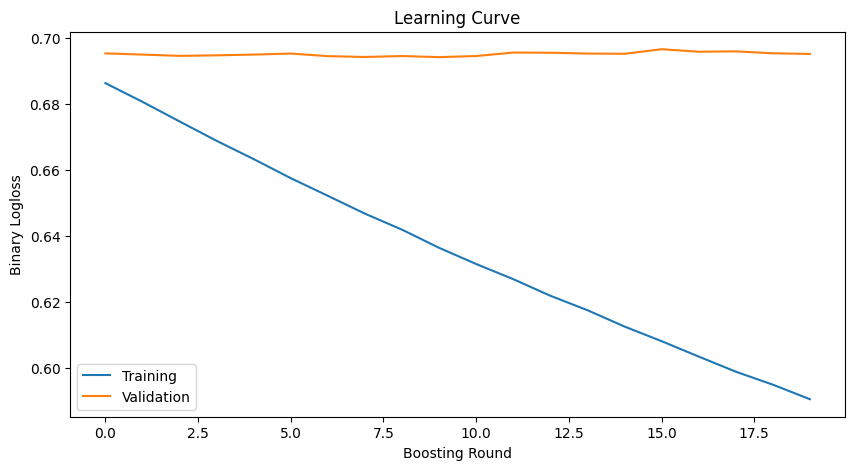

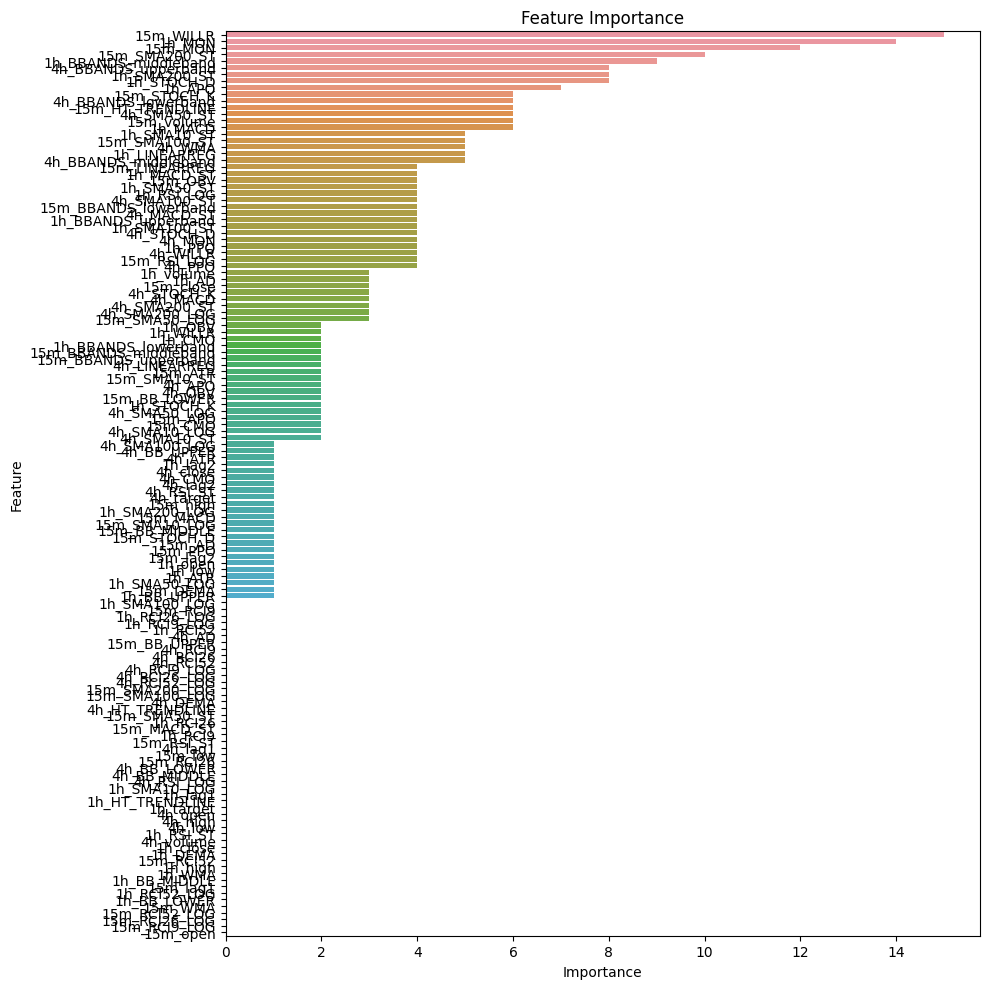

In [622]:
if __name__ == "__main__":
    file_names = [
        "data/BTCUSDT_15m_20210801_20221231.csv", 
        "data/BTCUSDT_1h_20210801_20221231.csv", 
        "data/BTCUSDT_4h_20210801_20221231.csv"]
    dfs = load_data(file_names)

    # 各タイムフレームのデータに対して特徴量エンジニアリングとラベル作成を行う
    processed_dfs = []
    for df in dfs:
        prefix = df.columns[0].split('_')[0]  # カラム名のプレフィックスを取得（例：15m）
        processed_df = feature_engineering(df, prefix)
        processed_df = create_label(processed_df, prefix)
        processed_dfs.append(processed_df)

    # 複数のタイムフレームのデータを結合（インデックスが一致するように注意）
    combined_df = pd.concat(processed_dfs, axis=1).dropna()
    display(combined_df)
    
    # さらに結合後に特徴量を追加する
    combined_df = add_features(combined_df)

    # モデルの学習と評価を行う
    model = train_and_evaluate(combined_df)
 
    # モデルを保存する
    model_path = os.path.join("model", "model.pkl")
    joblib.dump(model, model_path)